# Import Libraries and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
from sklearn import preprocessing
#import os
%matplotlib inline

df = pd.read_csv('/Users/jasongangel/Downloads/AIS/data/WorkOrder7538249_SAIS_2016-01.csv', usecols=['MMSI','PERIOD', 'Latitude', 'Longitude','SPEED_KNOTS', 'COG_DEG', 'SHIP_AND_CARGO_TYPE','DRAUGHT'], na_values ='None',low_memory=False, parse_dates=['PERIOD'])

df = df.rename(columns={'Latitude': 'LAT', 'Longitude': 'LON', 'SHIP_AND_CARGO_TYPE':'SHIP_TYPE'})

# Datashader Geospatial Plot

CPU times: user 473 ms, sys: 130 ms, total: 603 ms
Wall time: 573 ms


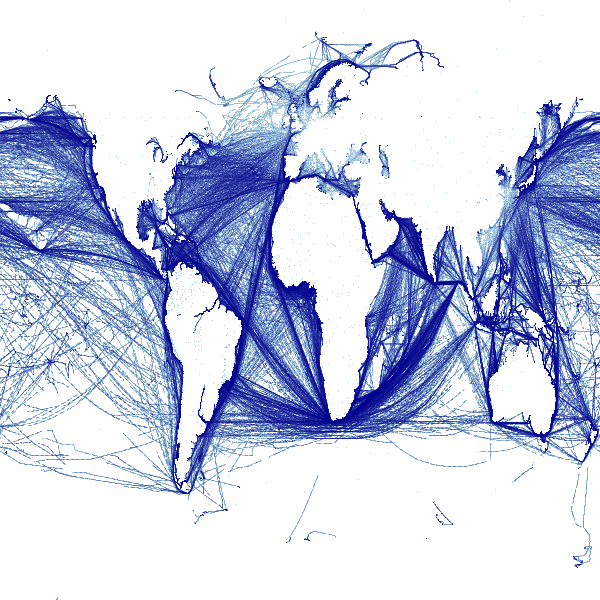

In [30]:
#DATASHADER
import datashader as ds
import datashader.transfer_functions as tf
import dask.dataframe as dd
dd = dd.read_csv('/Users/jasongangel/Downloads/AIS/data/Clean/Clean-01_16*.csv').persist()

canvas = ds.Canvas(plot_width=500, plot_height=300, 
                   x_range=(-8,8), y_range=(-8,8), 
                   x_axis_type='linear', y_axis_type='linear')

%time tf.shade(ds.Canvas().points(dd,'LON','LAT'))

#  Initial Data Look

In [3]:
df.head(5)

,MMSI,PERIOD,LAT,LON,SPEED_KNOTS,COG_DEG,SHIP_TYPE,DRAUGHT
0,229454000,2016-01-08 11:50:00,40.374271,-73.103733,15.9,92.0,79,10.0
1,229564000,2016-01-08 11:50:00,34.008233,-56.555884,11.9,73.0,70,13.6
2,229655000,2016-01-08 11:50:00,40.164743,-58.553108,19.1,59.9,70,12.9
3,249904000,2016-01-08 11:50:00,39.218795,-64.369931,18.0,72.1,70,9.9
4,209648000,2016-01-08 11:50:00,42.783833,-52.453734,11.7,290.5,70,16.4


In [4]:
#Dataframe Info (SHIP_TYPE and DRAUGHT contain bad str values in some cells thus they are detected as object types)
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7147784 entries, 0 to 7147783
Data columns (total 8 columns):
MMSI           int64
PERIOD         datetime64[ns]
LAT            float64
LON            float64
SPEED_KNOTS    float64
COG_DEG        float64
SHIP_TYPE      object
DRAUGHT        object
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 1.1 GB


In [5]:
# Stats : COG_DEG should not exceed 360 and SPEED_KNOTS should not exceed 35kts
df.describe()

,MMSI,LAT,LON,SPEED_KNOTS,COG_DEG
count,7.147784e+06,7.147784e+06,7.147784e+06,7.142174e+06,7.126317e+06
mean,4.182158e+08,3.553690e+00,1.590313e+01,1.023094e+01,1.814406e+02
std,1.407346e+08,2.949682e+01,9.489613e+01,5.685175e+00,1.005541e+02
min,4.000000e+00,-8.748081e+01,-1.799997e+02,0.000000e+00,0.000000e+00
25%,3.110040e+08,-2.170879e+01,-5.940824e+01,8.200000e+00,9.200000e+01
50%,3.722460e+08,3.580813e+00,1.184225e+01,1.180000e+01,1.844000e+02
75%,5.380042e+08,2.493482e+01,1.007303e+02,1.360000e+01,2.699000e+02
max,9.986662e+08,8.923451e+01,1.799979e+02,1.022000e+02,4.095000e+02


In [6]:
#Percentage of Rows w/ Missing Data
print((df.isnull().sum().sum()/df.shape[0])*100,'%')

0.8127414034895291 %


In [7]:
#Missing data per column
df.isnull().sum()

MMSI               0
PERIOD             0
LAT                0
LON                0
SPEED_KNOTS     5610
COG_DEG        21467
SHIP_TYPE          0
DRAUGHT        31016
dtype: int64

# Data clean 

In [8]:
#Copy df
df1 = df.copy()

MMSI

In [9]:
#Number of individual Vessels
print(df1['MMSI'].nunique(),'Individual Vessels')

27162 Individual Vessels


In [10]:
#Remove invalid MMSIs and sort by clean MMSIs
df1=df[(df['MMSI'] > 200000000)]

#Create Country Column from first three digits of MMSI
df1['MMSI'] = df1['MMSI'].astype(str)
df1['COUNTRY'] = df1['MMSI'].str.slice(start=0, stop=3)

#Drop MMSI Column
df1 = df1.drop(['MMSI'],axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


SPEED_KNOTS

In [11]:
#Drop null SPEED_KNOTS values
df1.dropna(how='any', axis=0, subset=['SPEED_KNOTS'], inplace=True)

#Drop Rows with speed over 35kts
df1=df1[df1.SPEED_KNOTS <= 35]

COG_DEG

In [12]:
#Remove any COG_DEG values above 360
df1 = df1[(df1['COG_DEG'] <= 360)]

#Forward fill COG_DEG Null values 
df1['COG_DEG'] = df1['COG_DEG'].fillna(method='ffill')

#Remove excess float precision
df1['COG_DEG'] = df1['COG_DEG'].astype(int)

SHIP_TYPE and DRAUGHT

In [13]:
#Fill DRAUGHT null values with 0
df1['DRAUGHT']= df1['DRAUGHT'].fillna(0)

#Cast SHIP_TYPE  and DRAUGHT to numeric type and mark incompatable values as NAN
df1[['SHIP_TYPE','DRAUGHT']] = df1[['SHIP_TYPE','DRAUGHT']].apply(pd.to_numeric,errors='coerce',axis=0)

#Filter out vessel types other than Cargo and Tanker vessesls
df1 = df1[(df1['SHIP_TYPE'] >= 70) & (df1['SHIP_TYPE'] <= 89)]

#Cast SHIP_TYPE as a str
df1['SHIP_TYPE'] = df1['SHIP_TYPE'].astype(str)

#Remove second digit of SHIP_TYPE (has no significance)
df1['SHIP_TYPE'] = df1['SHIP_TYPE'].str.slice(start=0, stop=1)

#Change Back to int
df1[['SHIP_TYPE']] = df1['SHIP_TYPE'].astype(int)

#Display count of unique vessel types
df1.SHIP_TYPE.value_counts()

7    4989513
8    1618326
Name: SHIP_TYPE, dtype: int64

Sort by Period

In [14]:
#Downcast float columns
cols = ['SPEED_KNOTS','COG_DEG', 'DRAUGHT','LAT','LON']
df1[cols] = df1[cols].round(2).apply(pd.to_numeric, downcast='float', axis=0)

#Downcast int columns
cols = ['SHIP_TYPE', 'COUNTRY']
df1[cols] = df1[cols].apply(pd.to_numeric, downcast='unsigned', axis=0)

#Sort by PERIOD
df1 = df1.sort_values('PERIOD')

# Clean Data Analysis

In [15]:
df1.head(10)

,PERIOD,LAT,LON,SPEED_KNOTS,COG_DEG,SHIP_TYPE,DRAUGHT,COUNTRY
0,2016-01-08 11:50:00,40.369999,-73.099998,15.900000,92.0,7,10.0,229
137,2016-01-08 11:50:00,32.340000,-76.730003,10.000000,207.0,7,9.7,259
138,2016-01-08 11:50:00,42.680000,-82.510002,9.500000,13.0,7,5.2,367
139,2016-01-08 11:50:00,43.029999,-53.119999,11.600000,107.0,7,16.6,441
140,2016-01-08 11:50:00,43.209999,-57.639999,16.700001,95.0,7,10.5,266
141,2016-01-08 11:50:00,40.259998,-73.459999,15.600000,304.0,7,9.6,271
142,2016-01-08 11:50:00,44.840000,-87.379997,0.100000,183.0,7,8.0,367
143,2016-01-08 11:50:00,37.970001,-43.230000,17.400000,271.0,7,9.0,367
144,2016-01-08 11:50:00,40.160000,-71.639999,1.200000,259.0,7,5.8,371
145,2016-01-08 11:50:00,44.740002,-43.660000,19.200001,61.0,8,5.6,470


In [16]:
df1.tail(10)

,PERIOD,LAT,LON,SPEED_KNOTS,COG_DEG,SHIP_TYPE,DRAUGHT,COUNTRY
7146725,2016-02-07 23:55:00,14.810000,-53.209999,11.3,101.0,8,9.300000,241
7146724,2016-02-07 23:55:00,11.510000,-60.369999,11.1,98.0,8,11.300000,240
7146723,2016-02-07 23:55:00,35.650002,-53.130001,13.0,83.0,8,9.200000,240
7146722,2016-02-07 23:55:00,-35.060001,-54.169998,7.6,72.0,8,16.799999,240
7146721,2016-02-07 23:55:00,10.290000,-64.959999,13.1,125.0,8,8.100000,240
7146720,2016-02-07 23:55:00,35.360001,-42.169998,11.7,251.0,8,14.000000,240
7146719,2016-02-07 23:55:00,34.910000,-21.410000,10.0,78.0,7,17.900000,240
7146718,2016-02-07 23:55:00,22.959999,-23.120001,11.9,25.0,7,8.300000,240
7146727,2016-02-07 23:55:00,36.029999,-31.440001,13.8,263.0,8,21.700001,241
7147783,2016-02-07 23:55:00,-34.759998,-57.889999,0.1,211.0,8,2.500000,998


In [17]:
df1.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6607839 entries, 0 to 7147783
Data columns (total 8 columns):
PERIOD         datetime64[ns]
LAT            float32
LON            float32
SPEED_KNOTS    float32
COG_DEG        float32
SHIP_TYPE      uint8
DRAUGHT        float32
COUNTRY        uint16
dtypes: datetime64[ns](1), float32(5), uint16(1), uint8(1)
memory usage: 245.8 MB


In [18]:
df1.describe(include='all')

,PERIOD,LAT,LON,SPEED_KNOTS,COG_DEG,SHIP_TYPE,DRAUGHT,COUNTRY
count,6607839,6.607839e+06,6.607839e+06,6.607839e+06,6.607839e+06,6.607839e+06,6.607839e+06,6.607839e+06
unique,4870,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2016-02-04 16:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2016-01-08 11:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2016-02-07 23:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,3.564790e+00,1.751209e+01,1.046747e+01,1.805674e+02,7.244910e+00,9.754210e+00,4.194263e+02
std,NaN,2.840377e+01,9.402737e+01,5.395728e+00,1.003438e+02,4.300339e-01,3.845214e+00,1.387571e+02
min,NaN,-8.748000e+01,-1.800000e+02,0.000000e+00,0.000000e+00,7.000000e+00,0.000000e+00,2.000000e+02
25%,NaN,-2.110000e+01,-5.675000e+01,9.100000e+00,9.100000e+01,7.000000e+00,7.200000e+00,3.110000e+02


In [19]:
#Check again for null values
df1.isnull().sum()

PERIOD         0
LAT            0
LON            0
SPEED_KNOTS    0
COG_DEG        0
SHIP_TYPE      0
DRAUGHT        0
COUNTRY        0
dtype: int64

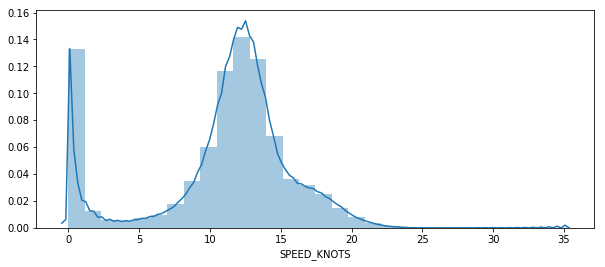

In [20]:
#SPEED_KNOTs Hist
plt.figure(figsize=(10,4))
sns.distplot(df1['SPEED_KNOTS'],kde=True,bins=30)

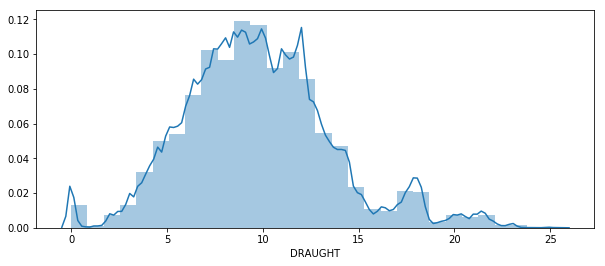

In [21]:
#DRAUGHT Hist
plt.figure(figsize=(10,4))
sns.distplot(df1['DRAUGHT'],kde=True,bins=30)

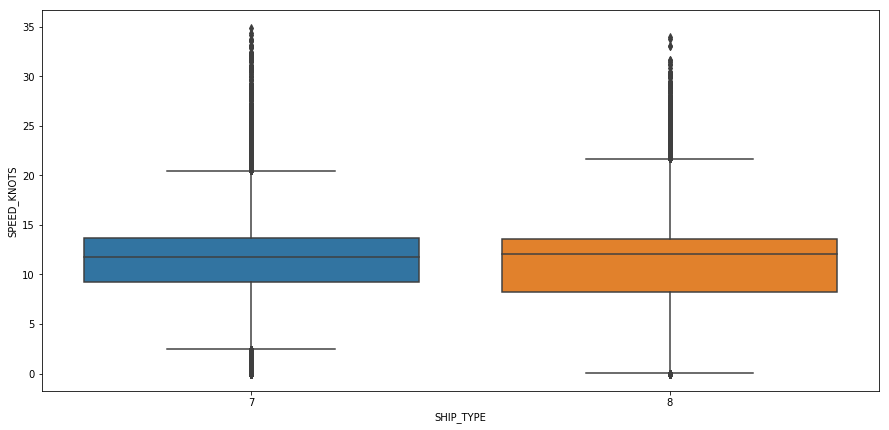

In [22]:
# Box Plot of SPEED_KNOTS by Cargo(7) and Tanker(8) vessels
plt.figure(figsize=(15,7))
sns.boxplot(x='SHIP_TYPE', y='SPEED_KNOTS',data=df1)

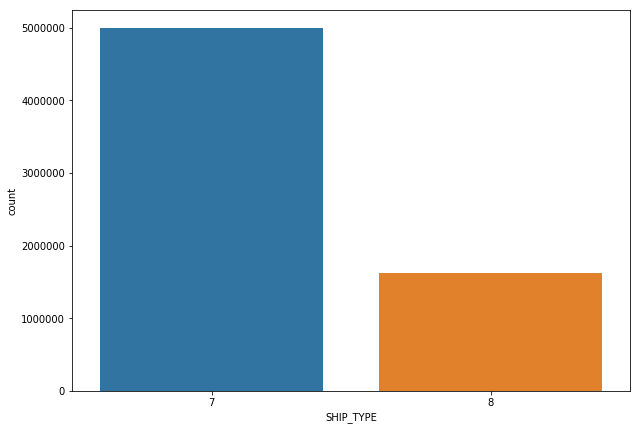

In [23]:
#Box Plot Count by SHIP_TYPE
plt.figure(figsize=(10,7))
sns.countplot(x='SHIP_TYPE',data=df1)

# Export

In [28]:
import csv
df1.to_csv('/Users/jasongangel/Downloads/AIS/data/Clean/Clean-01_16*.csv', index=False, encoding='utf-8')
quoting=csv.QUOTE_NONE

In [25]:
#from pandas import HDFStore,DataFrame

# create (or open) an hdf5 file and opens in append mode
#hdf = HDFStore('AIS_ALL.h5')

# put the dataset in the storage
#hdf.put('d1', df1, format='table', data_columns=True)

#hdf.append()
        
#hdf.close() # closes the file

In [26]:
#hdf = pd.read_hdf('AIS_ALL.h5', key='d1', mode='r')
#hdf.head()